In [1]:
import torch

In [187]:
def quantize_tensor(tensor,dtype=torch.int8):
    r_max = tensor.max()
    r_min = tensor.min()
    tensor_dtype = tensor.dtype
    q_max = torch.iinfo(dtype).max
    q_min = torch.iinfo(dtype).min
    #scale must be in higher precision
    if q_max - q_min == 0:
        q_max += 1e-9
    scale = torch.tensor((r_max-r_min)/(q_max-q_min),dtype=tensor_dtype)
    zero = int(torch.round(q_min - (r_min/scale)))
    if zero > q_max:
        zero = q_max
    if zero < q_min:
        zero = q_min
    q_tensor = tensor/scale + zero
    rounded_tensor = torch.round(q_tensor)
    rounded_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)
    return rounded_tensor,scale,zero

In [149]:
def de_quantize(tensor,scale,zero,dtype=torch.float32):
    deq_tensor = scale * (tensor.float() - zero)
    return deq_tensor

In [150]:
def sym_quant(tensor,dtype):
    r_max = tensor.abs().max()
    q_min,q_max = torch.iinfo(dtype).min,torch.iinfo(dtype).max
    scale = r_max/q_max
    q_t =  tensor/scale
    q_t = torch.round(q_t).to(dtype)
    return q_t,scale

In [154]:
def per_channel_sym_quant(tensor,dim,dtype=torch.int8):
    output_dim = tensor.shape[dim]
    qs,scales,zeros= [],[],[]
    for index in range(output_dim):
        sub_tensor = tensor.select(dim,index)
        q,s,z = quantize_tensor(sub_tensor,dtype)
        qs.append(q)
        scales.append(s)
        zeros.append(0)
    qs = torch.stack(qs,dim)
    return qs,scales,zeros

In [4]:
def per_channel_quant(tensor,dim,dtype=torch.int8):
    output_dim = tensor.shape[dim]
    qs,scales,zeros = [],[],[]
    for index in range(output_dim):
        sub_tensor = tensor.select(dim,index)
        q,s,z = quantize_tensor(sub_tensor,dtype)
        qs.append(q)
        scales.append(s)
        zeros.append(z)
    qs = torch.stack(qs,dim)
    return qs,scales,zeros

In [5]:
def per_channel_de_quant(tensor,scales,zeros,dim,dtype=torch.float32):
    output_dim = tensor.shape[dim]
    de_qs = []
    for index in range(output_dim):
        sub_tensor = tensor.select(dim,index)
        de_q = de_quantize(sub_tensor,scales[index],zeros[index],dtype)
        de_qs.append(de_q)
    de_qs = torch.stack(de_qs,dim)
    return de_qs

### dim =0

In [240]:
dim_0 = 0
z = torch.randint(low=-600,high=600,size=(8,8)) + torch.randn((8,8))
q_z_0,scales_0,zeros_0 = per_channel_quant(z,dim_0,dtype=torch.int8)

/var/folders/xw/knd54pd91c7cw57n21dntvx80000gn/T/ipykernel_24751/3746070839.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor((r_max-r_min)/(q_max-q_min),dtype=tensor_dtype)


In [241]:
q_z_0

tensor([[ 127, -100,   44, -109,   70,  125,  -41, -128],
        [ -29,   10, -112,    5,  -35,  127, -128,   66],
        [  70,  119, -128,  -41,   48,  -52,  -53,  127],
        [ -20,  -34,  127, -128,  120,  -58,   -4, -124],
        [  56,  -23, -128,    0,  -42, -115,   40,  127],
        [  45,  -71, -128,  127,   34,  -58,   94,   90],
        [  45,  -72,  127,   51,  -50,  -96, -128, -109],
        [-106,  -88,  -70,   54,  127,  -74,  -26, -128]], dtype=torch.int8)

In [242]:
de_q_z_0 = per_channel_de_quant(q_z_0,scales_0,zeros_0,dim_0)

In [243]:
de_q_z_0

tensor([[ 154.4024, -482.8583,  -78.6048, -508.1241,   -5.6146,  148.7877,
         -317.2267, -561.4631],
        [-221.3019,  -88.5208, -503.8875, -105.5440, -241.7298,  309.8227,
         -558.3618,  102.1394],
        [ 271.0338,  485.2380, -594.5259, -214.2042,  174.8605, -262.2908,
         -266.6624,  520.2101],
        [-221.3110, -262.0788,  206.7510, -535.8055,  186.3671, -331.9664,
         -174.7192, -524.1575],
        [  54.5732, -214.8822, -573.0191, -136.4331, -279.6879, -528.6783,
            0.0000,  296.7420],
        [ 253.9891, -105.3126, -281.8660,  507.9782,  219.9174,  -65.0460,
          405.7631,  393.3734],
        [ 257.1069, -114.2697,  517.3879,  276.1518,  -44.4382, -190.4495,
         -292.0226, -231.7136],
        [-156.4120, -107.0187,  -57.6255,  282.6392,  482.9563,  -68.6017,
           63.1136, -216.7815]])

In [244]:
z

tensor([[ 154.2105, -482.2002,  -79.4163, -508.9303,   -4.4441,  149.4742,
         -317.7845, -561.6549],
        [-221.7251,  -88.2224, -503.3609, -104.2562, -240.0316,  310.2943,
         -557.8901,  103.0481],
        [ 269.2234,  486.2086, -595.6793, -214.0605,  175.6633, -261.4417,
         -265.3140,  519.0568],
        [-221.8787, -262.4482,  206.1024, -536.4542,  187.1391, -333.4087,
         -174.4280, -522.8519],
        [  55.0541, -213.7617, -572.4310, -136.1936, -280.6105, -527.6876,
           -1.2765,  297.3302],
        [ 253.6416, -104.5104, -280.5247,  509.3195,  221.0298,  -65.3526,
          404.9150,  393.8723],
        [ 256.5484, -113.7408,  515.9292,  274.7394,  -45.0438, -190.5334,
         -293.4813, -231.4668],
        [-156.9243, -106.2795,  -58.5516,  282.3469,  484.1919,  -69.6119,
           62.9202, -215.5459]])

tensor(0.8074)

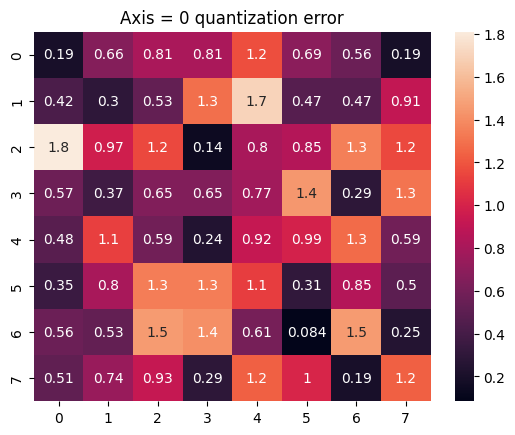

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(abs(z-de_q_z_0),annot=True)
plt.title("Axis = 0 quantization error")
err = torch.abs(z-de_q_z_0)
torch.square(err).mean()

### dim 1

In [188]:
import numpy as np
errs = []
for i in range(1000):
    dim_1 = 1
    z = torch.randint(low=-600,high=600,size=(3,3)) + torch.randn((3,3))
    q_z_1,scales_1,zeros_1 = per_channel_quant(z,dim_1,dtype=torch.int8)
    de_q_z_1 = per_channel_de_quant(q_z_1,scales_1,zeros_1,dim_1)
    err = torch.abs(z-de_q_z_1)
    errs.append(err)
print(np.mean(errs))

21.798882


/var/folders/xw/knd54pd91c7cw57n21dntvx80000gn/T/ipykernel_24751/3746070839.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor((r_max-r_min)/(q_max-q_min),dtype=tensor_dtype)
